# Volume Spread Analysis with Python

Indicator inspired from Volume Spread Analysis. This indicator models the relationship between the candle range and volume with a linear regression. Then it predicts the current candle's range with the current volume. If the actual range is higher than expected the indicator will output a positive value. If the actual range is lower than expected the indicator will output a negative value. Extreme values output by this indicator mark points of interest where trade entries/exits could be considered.

* Tutorial: [Volume Spread Analysis with Python | Algorithmic Trading Indicator](https://www.youtube.com/watch?v=FmPThiXtLYc)
* Full Code: https://github.com/neurotrader888/VSAIndicator

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import mplfinance as mpf

### Volume Spread Analysis Indicator

In [2]:
# Load data
data = pd.read_csv('src/BTCUSDT3600V.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

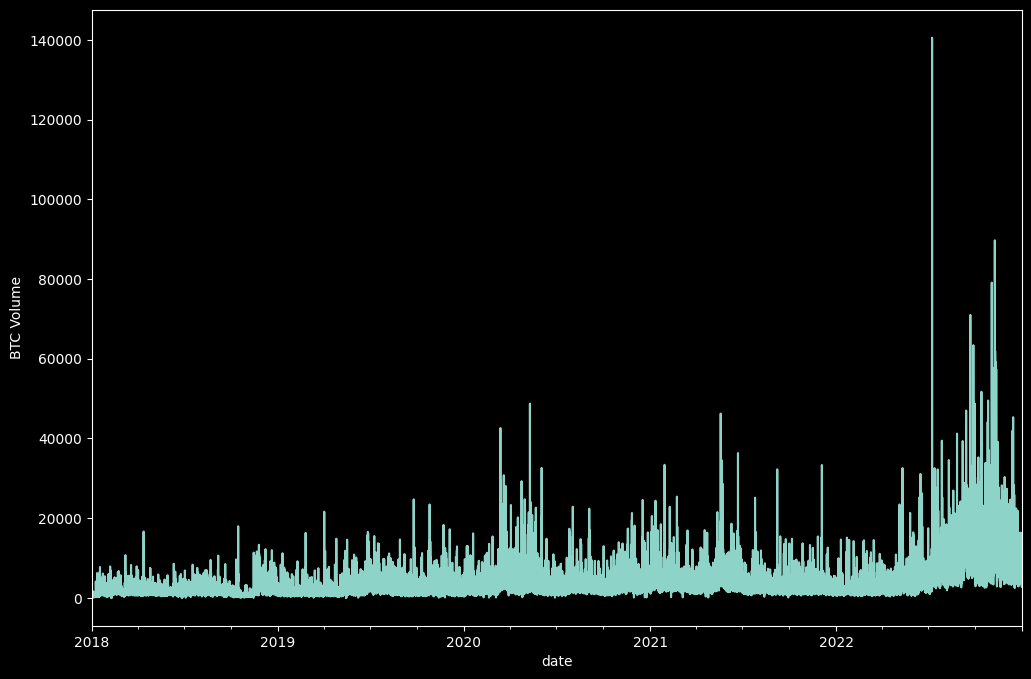

In [3]:
plt.style.use('dark_background')

# Plot raw volume and range
data['volume'].plot(figsize=(12, 8))
plt.ylabel("BTC Volume")
plt.show()

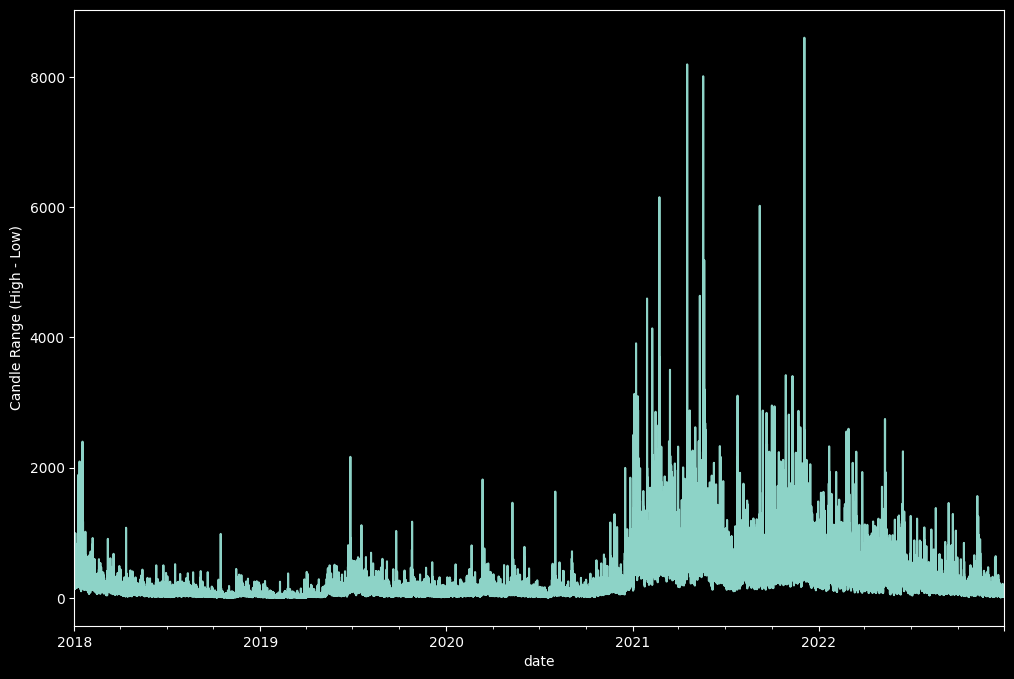

In [4]:
(data['high'] - data['low']).plot(figsize=(12, 8))
plt.ylabel("Candle Range (High - Low)")
plt.show()

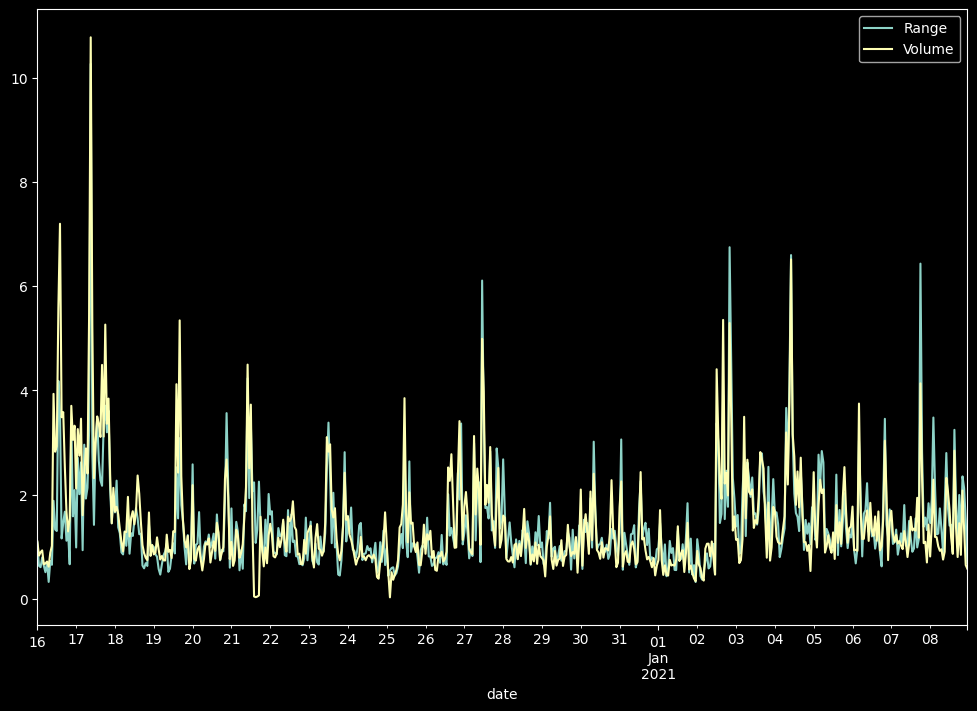

In [5]:
# Get relative range/volume
#  24 * 7 = 168
atr = ta.atr(data['high'], data['low'], data['close'], 168)
data['norm_range'] = (data['high'] - data['low']) / atr

volume_median = data['volume'].rolling(168).median()
data['norm_volume'] = data['volume'] / volume_median

plt.figure(figsize=(12, 8))
data['norm_range']['2020-12-16':'2021-01-08'].plot(label='Range')
data['norm_volume']['2020-12-16':'2021-01-08'].plot(label='Volume')
plt.legend()
plt.show()

Volume - Range Correlation 0.8112856403620159


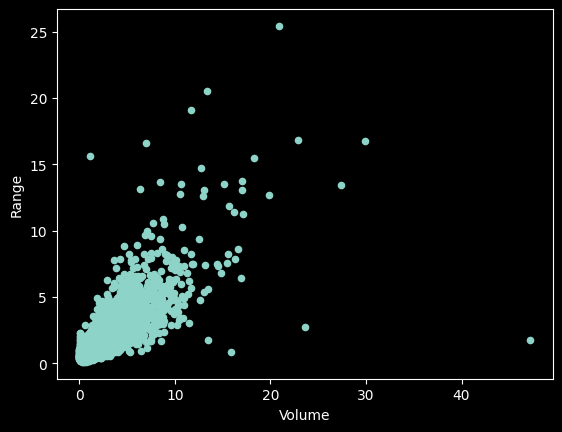

In [6]:
print("Volume - Range Correlation", data['norm_range'].corr(data['norm_volume']))
data.plot.scatter('norm_volume', 'norm_range')
plt.xlabel("Volume")
plt.ylabel("Range")
plt.show()

### Relative Volume vs. Range Scatter Window of 1 Week of Hourly Data

In [7]:
# Load data
data = pd.read_csv('src/BTCUSDT3600V.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

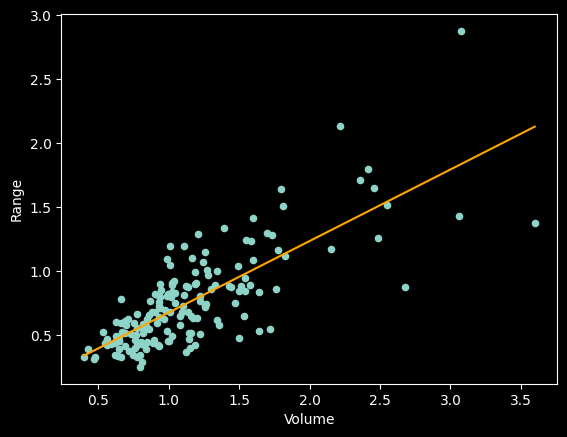

In [8]:
plt.style.use('dark_background')

# Get relative range/volume
#  24 * 7 = 168
atr = ta.atr(data['high'], data['low'], data['close'], 168)
data['norm_range'] = (data['high'] - data['low']) / atr

volume_median = data['volume'].rolling(168).median()
data['norm_volume'] = data['volume'] / volume_median

# Random 1 week slice
data = data.iloc[1000:1168]
slope, intercept, _, _, std_err = stats.linregress(data['norm_volume'], data['norm_range'])

p1 = intercept + slope * data['norm_volume'].min()
p2 = intercept + slope * data['norm_volume'].max()

data.plot.scatter('norm_volume', 'norm_range')
plt.xlabel("Volume")
plt.ylabel("Range")
plt.plot([data['norm_volume'].min(), data['norm_volume'].max()], [p1, p2],color='orange')
plt.show()

### VSA Indicator Histogram

In [9]:
def vsa_indicator(data: pd.DataFrame, norm_lookback: int = 168):
    # Norm lookback should be fairly large

    atr = ta.atr(data['high'], data['low'], data['close'], norm_lookback)
    vol_med = data['volume'].rolling(norm_lookback).median()

    data['norm_range'] = (data['high'] - data['low']) / atr 
    data['norm_volume'] = data['volume'] / vol_med 

    norm_vol = data['norm_volume'].to_numpy()
    norm_range = data['norm_range'].to_numpy()

    range_dev = np.zeros(len(data))
    range_dev[:] = np.nan

    for i in range(norm_lookback * 2, len(data)):
        window = data.iloc[i - norm_lookback + 1: i+ 1]
        slope, intercept, r_val,_,_ = stats.linregress(window['norm_volume'], window['norm_range'])

        if slope <= 0.0 or r_val < 0.2:
            range_dev[i] = 0.0
            continue
       
        pred_range = intercept + slope * norm_vol[i]
        range_dev[i] = norm_range[i] - pred_range
        
    return pd.Series(range_dev, index=data.index)


def plot_around(data: pd.DataFrame, i: int, above: bool, threshold: float = 0.90):
    if above:
        extremes = data[data['dev'] > threshold]
    else:
        extremes = data[data['dev'] < -threshold]
    
    if i >= len(extremes):
        raise ValueError(f"i is too big, use less than {len(extremes)}")
    t =  extremes.index[i]
    td = pd.Timedelta(hours=24)
    surrounding = data.loc[t - td: t + td]
    
    plt.style.use('dark_background')
    fig, axs = plt.subplots(3, sharex=True, height_ratios=[3, 1, 1], figsize=(12, 10))
    add = mpf.make_addplot(surrounding['dev'], ax=axs[2], title='VSA Indicator')
    axs[1].set_title('Volume')
    mco = [None] * len(surrounding)
    mco[24] = 'orange'
    mpf.plot(surrounding, volume=axs[1], type='candle', style='charles', ax=axs[0], addplot=[add], marketcolor_overrides=mco,mco_faceonly=False)
    plt.show()

In [10]:
# Load data
data = pd.read_csv('src/BTCUSDT3600V.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

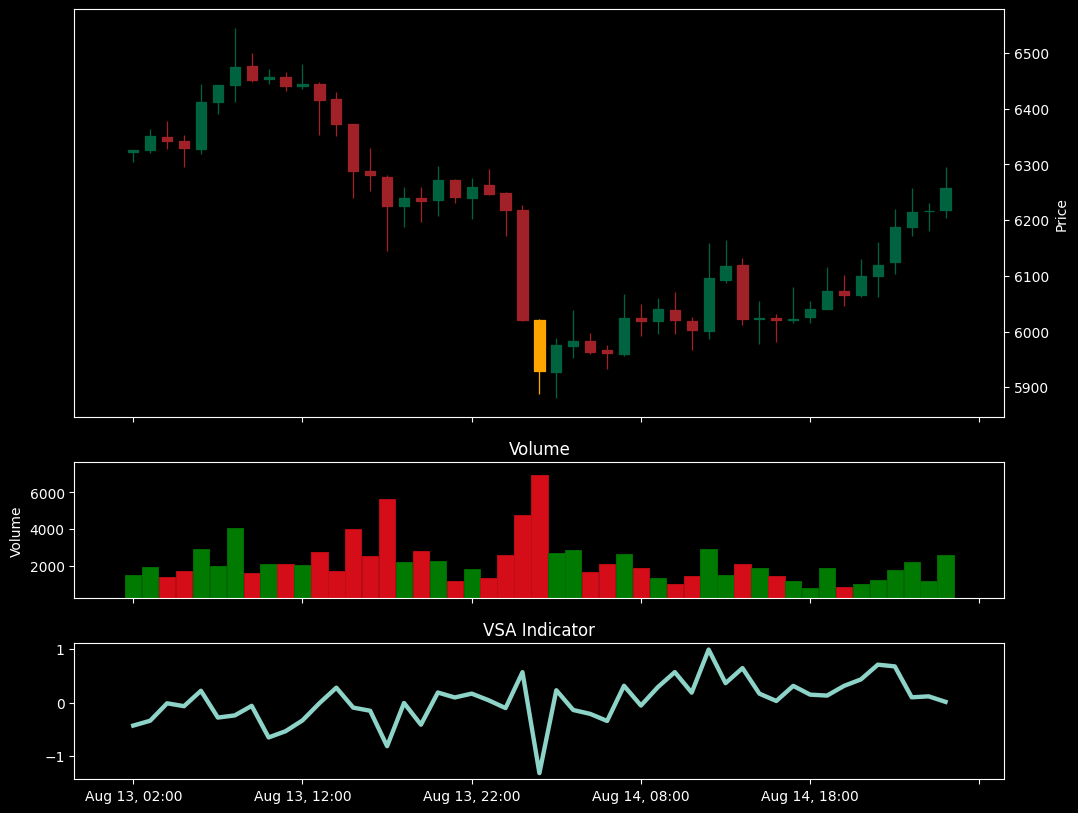

In [11]:
data['dev'] = vsa_indicator(data, 168)
plot_around(data, 21, False, 1.0)